In [1]:
from nnfs.datasets import sine_data
X, y = sine_data()

In [2]:
class Model:
    def __init__(self):
        self.layers = []
        
    def add(self, layer):
        self.layers.append(layer)

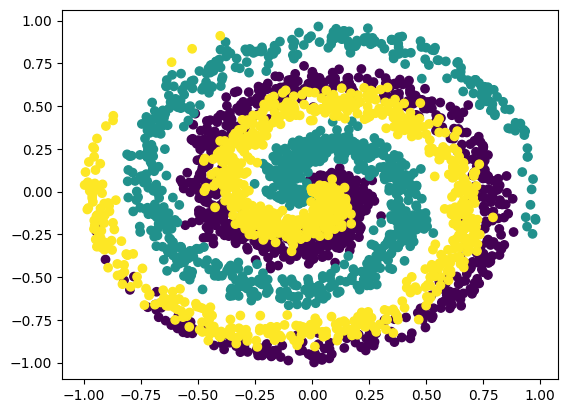

epoch: 100, acc:  0.720, loss:  0.719 (data_loss:  0.658, reg_loss:  0.061), lr: 0.04975371909050202
epoch: 200, acc:  0.788, loss:  0.609 (data_loss:  0.530, reg_loss:  0.079), lr: 0.049507401356502806
epoch: 300, acc:  0.796, loss:  0.594 (data_loss:  0.513, reg_loss:  0.080), lr: 0.0492635105177595
epoch: 400, acc:  0.831, loss:  0.536 (data_loss:  0.456, reg_loss:  0.080), lr: 0.04902201088288642
epoch: 500, acc:  0.823, loss:  0.528 (data_loss:  0.447, reg_loss:  0.082), lr: 0.048782867456949125
epoch: 600, acc:  0.830, loss:  0.515 (data_loss:  0.438, reg_loss:  0.077), lr: 0.04854604592455945
epoch: 700, acc:  0.822, loss:  0.560 (data_loss:  0.486, reg_loss:  0.074), lr: 0.048311512633460556
epoch: 800, acc:  0.847, loss:  0.478 (data_loss:  0.403, reg_loss:  0.075), lr: 0.04807923457858551
epoch: 900, acc:  0.840, loss:  0.506 (data_loss:  0.435, reg_loss:  0.070), lr: 0.04784917938657352
epoch: 1000, acc:  0.845, loss:  0.476 (data_loss:  0.405, reg_loss:  0.071), lr: 0.04762

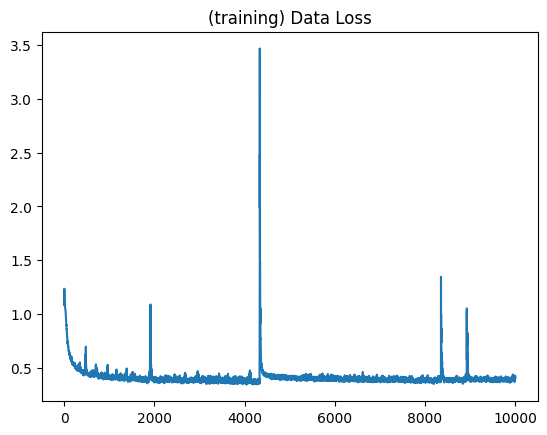

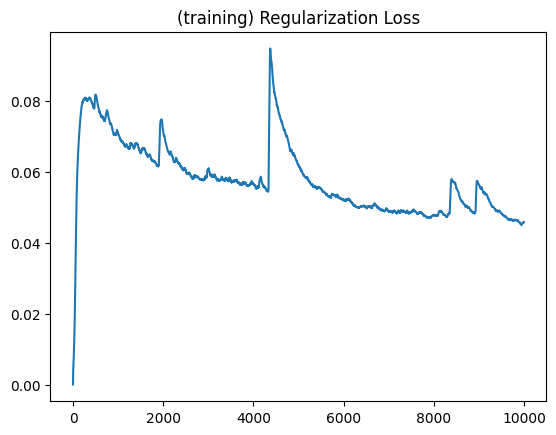

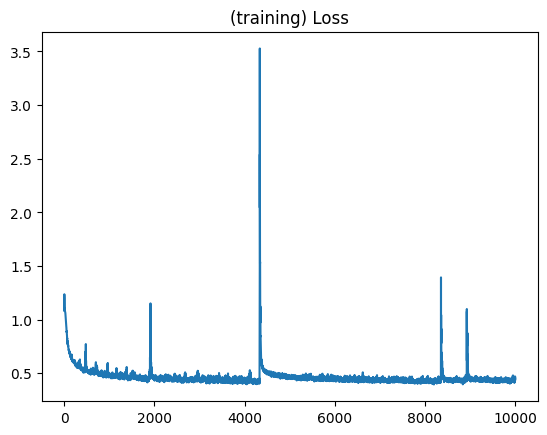

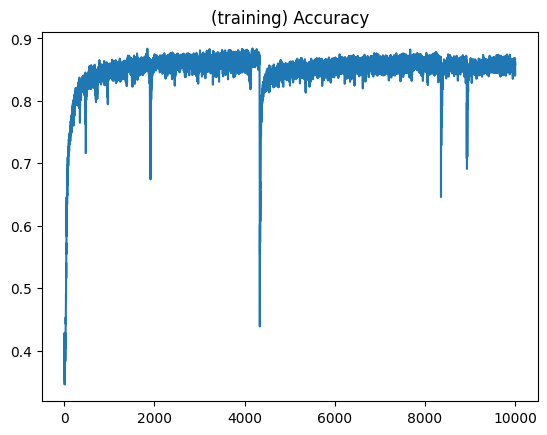

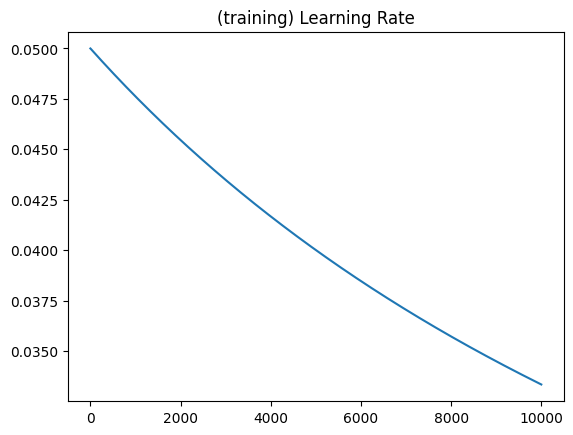

validation, acc:  0.843, loss:  0.385


In [3]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
            
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
            
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
            
        self.dinputs = np.dot(dvalues, self.weights.T)
        
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate
    
    def forward(self, inputs, training):
        self.inputs = inputs
        
        if not training:
            self.output = inputs.copy()
            return
        
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        
class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs

class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
    def predictions(self, outputs):
        return outputs

class Activation_Softmax:
    def forward(self, inputs, training):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
            
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)
    
class Activation_Sigmoid:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output
        
    def predictions(self, outputs):
        return (outputs > 0.5) * 1
    
class Activation_Linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
    def predictions(self, outputs):
        return outputs
    
class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if self. momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
        
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
        
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
            
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_Adagrad:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweight**2
        layer.bias_cache += layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_updata_params(self):
        self.iterations += 1
        
class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cahce = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
                
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
                
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
                
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
                
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
        
    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        
        if not include_regularization:
            return data_loss
        
        return data_loss, self.regularization_loss()
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
            
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples
        
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
        
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples
    
class Loss_BinaryCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples
        
class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs - self.dinputs / samples
        
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
class Accuracy:
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)
        return accuracy       
        
class Accuracy_Categorical(Accuracy):
    def __init__(self, *, binary=False):
        self.binary = binary
        
    def init(self, y):
        pass
    
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y
    
class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None
    
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250
            
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision
    
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
        
    def add(self, layer):
        self.layers.append(layer)
        
    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss 
        self.optimizer = optimizer
        self.accuracy = accuracy
        
    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
                
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
                
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
                
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        
        self.loss.remember_trainable_layers(self.trainable_layers)
        
        if isinstance(self.layers[-1], Activation_Softmax) and isinstance(self.loss, Loss_CategoricalCrossentropy):
            self.softmax_classifier_output = Activation_Softmax_Loss_CategoricalCrossentropy()
    
    def train(self, X, y, *, epochs=1, print_every=1, validation_data=None):
        self.accuracy.init(y)
        
        data_losses = []
        regularization_losses = []
        losses = []
        accuracies = []
        learning_rates = []
        
        for epoch in range(1, epochs+1):
            output = self.forward(X, training=True)
            
            data_loss, regularization_loss = self.loss.calculate(output, y, include_regularization=True)
            data_losses.append(data_loss)
            regularization_losses.append(regularization_loss)
            loss = data_loss + regularization_loss
            losses.append(loss)
            
            predictions = self.output_layer_activation.predictions(output)
            accuracy = self.accuracy.calculate(predictions, y)
            accuracies.append(accuracy)
            
            learning_rates.append(self.optimizer.current_learning_rate)
            
            self.backward(output, y)
            
            self.optimizer.pre_update_params()
            for layer in self.trainable_layers:
                self.optimizer.update_params(layer)
            self.optimizer.post_update_params()
            
            if not epoch % print_every:
                print(f'epoch: {epoch}, ' +
                      f'acc: {accuracy: .3f}, ' + 
                      f'loss: {loss: .3f} (' +
                      f'data_loss: {data_loss: .3f}, ' +
                      f'reg_loss: {regularization_loss: .3f}), ' +
                      f'lr: {self.optimizer.current_learning_rate}')
        
        plt.plot(range(10000), data_losses)
        plt.title('(training) Data Loss')
        plt.show()
        plt.plot(range(10000), regularization_losses)
        plt.title('(training) Regularization Loss')
        plt.show()
        plt.plot(range(10000), losses)
        plt.title('(training) Loss')
        plt.show()
        plt.plot(range(10000), accuracies)
        plt.title('(training) Accuracy')
        plt.show()
        plt.plot(range(10000), learning_rates)
        plt.title('(training) Learning Rate')
        plt.show()
        
        if validation_data is not None:
            X_val, y_val = validation_data
            
            output = self.forward(X_val, training=False)
            
            loss = self.loss.calculate(output, y_val)
            
            predictions = self.output_layer_activation.predictions(output)
            accuracy = self.accuracy.calculate(predictions, y_val)
            
            print(f'validation, ' +
                  f'acc: {accuracy: .3f}, ' +
                  f'loss: {loss: .3f}')
            
    def forward(self, X, training):
        self.input_layer.forward(X, training)
        
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
        
        return layer.output
    
    def backward(self, output, y):
        if self.softmax_classifier_output is not None:
            self.softmax_classifier_output.backward(output, y)
            
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
                
            return
        
        self.loss.backward(output, y)
        
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
            


X, y = spiral_data(samples=1000, classes=3)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

X_test, y_test = spiral_data(samples=100, classes=3)

model = Model()

model.add(Layer_Dense(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4))
model.add(Activation_ReLU())
model.add(Layer_Dropout(0.1))
model.add(Layer_Dense(512, 3))
model.add(Activation_Softmax())

model.set(
    loss = Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(learning_rate=0.05, decay=5e-5),
    accuracy=Accuracy_Categorical()
)

model.finalize()

model.train(X, y, validation_data=(X_test, y_test), epochs=10000, print_every=100)